In [1]:
import sys, importlib
sys.path.append('../')

from Modules.Utils.Imports import *
from Modules.Utils.PDESolver import *
from Modules.Models.BuildBINNs import BINN
from Modules.Utils.ModelWrapper import ModelWrapper

In [2]:
device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))

Device set to cpu


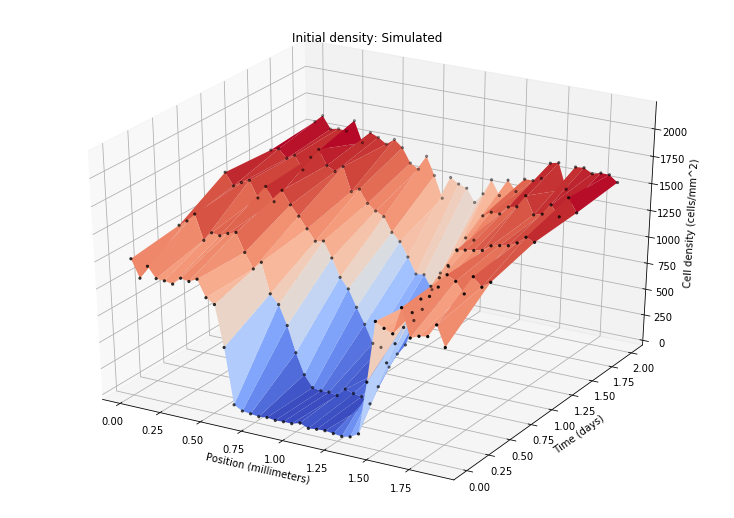

In [3]:
#
# Simulated data
#

path = '../Data/'
file_name = 'porous_fisher_KPP_data.npy' # fisher_KPP_data.npy, porous_fisher_KPP_data.npy

# load data
file = np.load(path + file_name, allow_pickle=True).item()

# extract data
density='     Simulated'
U = file['outputs'].copy()
shape = U.shape
U_clean = file['clean'].copy()
x = np.unique(file['inputs'][:,0]).copy()
t = np.unique(file['inputs'][:,1]).copy()
X = file['inputs'][:,0].copy().reshape(shape)
T = file['inputs'][:,1].copy().reshape(shape) 
D = file['D']
r = file['r']
K = file['K']
gamma = 0.2

# variable scales
x_scale = 1/1000 # micrometer -> millimeter
t_scale = 1/24 # hours -> days
u_scale = 1/(x_scale**2) # cells/um^2 -> cells/mm^2

# compute extrema
x_min, x_max = np.min(x), np.max(x)
t_min, t_max = np.min(t), np.max(t)
u_min, u_max = np.min(U), np.max(U)

# prepare for surface fit
inputs = np.concatenate([X.reshape(-1)[:, None],
                         T.reshape(-1)[:, None]], axis=1)
outputs = U.reshape(-1)[:, None]

# plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X, T, U, cmap=cm.coolwarm, alpha=1)
ax.scatter(X.reshape(-1), T.reshape(-1), U.reshape(-1), s=5, c='k')
plt.title('Initial density: '+density[5:])
ax.set_xlabel('Position (millimeters)')
ax.set_ylabel('Time (days)')
ax.set_zlabel('Cell density (cells/mm^2)')
ax.set_zlim(0, 2.2e3)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.show()

In [4]:
def to_torch(ndarray):
    arr = torch.tensor(ndarray, dtype=torch.float)
    arr.requires_grad_(True)
    arr = arr.to(device)
    return arr

# split into train/val
N = len(inputs)
split = int(0.8*N)
p = np.random.permutation(N)
x_train = inputs[p[:split]]
y_train = outputs[p[:split]]
x_val = inputs[p[split:]]
y_val = outputs[p[split:]]

# convert to pytorch
x_train = to_torch(x_train)
y_train = to_torch(y_train)
x_val = to_torch(x_val)
y_val = to_torch(y_val)
inputs = to_torch(inputs)
outputs = to_torch(outputs)

In [5]:
# compile 
binn = BINN(delay=False).to(device)
parameters = binn.parameters()
opt = torch.optim.Adam(parameters, lr=1e-3)
model = ModelWrapper(
    model=binn,
    optimizer=opt,
    loss=binn.loss,
    augmentation=None,
    save_name='../Weights/')
save_name = file_name[:-4]+'_simulated' 
model.save_name += save_name

In [ ]:
epochs = int(1e6)
batch_size = 37
rel_save_thresh = 0.05

# train jointly
model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=None,#[batch_callback, epoch_callback],
    verbose=1,
    validation_data=[x_val, y_val],
    early_stopping=5000,
    rel_save_thresh=rel_save_thresh)

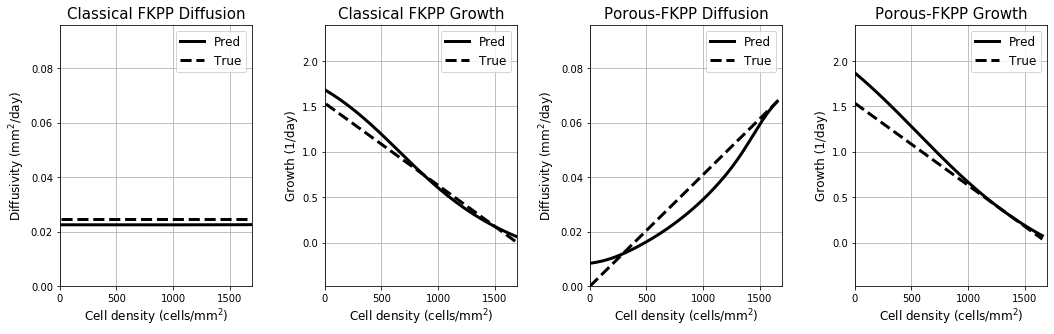

In [6]:
#
# simulated model and parameter fits
#

weight = '_IC1e1'

def to_torch(x):
    return torch.from_numpy(x).float().to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()

fig = plt.figure(figsize=(15,5))

#
# FKPP
#

# load data
path = '../Data/'
file_name = 'fisher_KPP_data.npy' 
file = np.load(path + file_name, allow_pickle=True).item()
density='     Simulated'
U = file['outputs'].copy()
u0 = U[:,0].copy()
shape = U.shape
U_clean = file['clean'].copy()
x = np.unique(file['inputs'][:,0]).copy()
t = np.unique(file['inputs'][:,1]).copy()
X = file['inputs'][:,0].copy().reshape(shape)
T = file['inputs'][:,1].copy().reshape(shape) 
D = file['D']
r = file['r']
K = file['K']
gamma = 0.2
x_min, x_max = np.min(x), np.max(x)
t_min, t_max = np.min(t), np.max(t)
u_min, u_max = np.min(U), np.max(U)
inputs = np.concatenate([X.reshape(-1)[:, None],T.reshape(-1)[:, None]], axis=1)
outputs = U.reshape(-1)[:, None]

# load model
model.save_name = '../Weights/'
model.save_name += file_name[:-4]+'_simulated'
model.load(model.save_name+'_'+binn.name+weight+'_best_eval_model', device=device)

# evaluate parameters
u_mesh = np.linspace(np.min(U), np.max(U), 201)
t_mesh = np.linspace(0, 2, 201)
D_mesh = to_numpy(binn.diffusion(to_torch(u_mesh)[:, None])) 
G_mesh = to_numpy(binn.growth(to_torch(u_mesh)[:, None])) 
T_mesh = to_numpy(binn.delay1(to_torch(t_mesh)[:, None]))
D_mesh *= np.max(T_mesh)
G_mesh *= np.max(T_mesh)
T_mesh /= np.max(T_mesh)

# plot
ax1 = fig.add_subplot(1, 4, 1)
ax1.set_xlabel(r'Cell density (cells/mm$^2$)', fontsize=12)
ax1.set_ylabel(r'Diffusivity (mm$^2$/day)', fontsize=12)
ax1.set_xlim(0, 1.7e3)
ax1.set_ylim(model.model.diffusion.min, model.model.diffusion.max)
ax1.set_title(r'Classical FKPP Diffusion', fontsize=15)
plt.grid()
ax2 = fig.add_subplot(1, 4, 2)
ax2.set_xlabel(r'Cell density (cells/mm$^2$)', fontsize=12)
ax2.set_ylabel('Growth (1/day)', fontsize=12)
ax2.set_xlim(0, 1.7e3)
ax2.set_ylim(model.model.growth.min, model.model.growth.max)
ax2.set_title(r'Classical FKPP Growth', fontsize=15)
plt.grid()

ax1.plot(u_mesh, D_mesh, 'k-', linewidth=3)
ax1.plot(u_mesh, D*np.ones_like(u_mesh), 'k--', linewidth=3)
ax1.legend([r'Pred', r'True'], fontsize=12)

ax2.plot(u_mesh, G_mesh, 'k-', linewidth=3)
ax2.plot(u_mesh, r*(1-u_mesh/K), 'k--', linewidth=3)
ax2.legend([r'Pred', r'True'], fontsize=12)

#
# PFKPP
#

# load data
path = '../Data/'
file_name = 'porous_fisher_KPP_data.npy'
file = np.load(path + file_name, allow_pickle=True).item()
density='     Simulated'
U = file['outputs'].copy()
u0 = U[:,0].copy()
shape = U.shape
U_clean = file['clean'].copy()
x = np.unique(file['inputs'][:,0]).copy()
t = np.unique(file['inputs'][:,1]).copy()
X = file['inputs'][:,0].copy().reshape(shape)
T = file['inputs'][:,1].copy().reshape(shape) 
D = file['D']
r = file['r']
K = file['K']
gamma = 0.2
x_min, x_max = np.min(x), np.max(x)
t_min, t_max = np.min(t), np.max(t)
u_min, u_max = np.min(U), np.max(U)
inputs = np.concatenate([X.reshape(-1)[:, None],T.reshape(-1)[:, None]], axis=1)
outputs = U.reshape(-1)[:, None]

# load model
model.save_name = '../Weights/'
model.save_name += file_name[:-4]+'_simulated'
model.load(model.save_name+'_'+binn.name+weight+'_best_eval_model', device=device)

#
# plot learned parameters
#

# evaluate parameters
u_mesh = np.linspace(np.min(U), np.max(U), 201)
t_mesh = np.linspace(0, 2, 201)
D_mesh = to_numpy(binn.diffusion(to_torch(u_mesh)[:, None])) 
G_mesh = to_numpy(binn.growth(to_torch(u_mesh)[:, None])) 
T_mesh = to_numpy(binn.delay1(to_torch(t_mesh)[:, None]))
D_mesh *= np.max(T_mesh)
G_mesh *= np.max(T_mesh)
T_mesh /= np.max(T_mesh)

# plot
ax1 = fig.add_subplot(1, 4, 3)
ax1.set_xlabel(r'Cell density (cells/mm$^2$)', fontsize=12)
ax1.set_ylabel(r'Diffusivity (mm$^2$/day)', fontsize=12)
ax1.set_xlim(0, 1.7e3)
ax1.set_ylim(model.model.diffusion.min, model.model.diffusion.max)
ax1.set_title(r'Porous-FKPP Diffusion', fontsize=15)
plt.grid()
ax2 = fig.add_subplot(1, 4, 4)
ax2.set_xlabel(r'Cell density (cells/mm$^2$)', fontsize=12)
ax2.set_ylabel('Growth (1/day)', fontsize=12)
ax2.set_xlim(0, 1.7e3)
ax2.set_ylim(model.model.growth.min, model.model.growth.max)
ax2.set_title(r'Porous-FKPP Growth', fontsize=15)
plt.grid()

ax1.plot(u_mesh, D_mesh, 'k-', linewidth=3)
ax1.plot(u_mesh, D*u_mesh/K, 'k--', linewidth=3)
ax1.legend([r'Pred', r'True'], fontsize=12)

ax2.plot(u_mesh, G_mesh, 'k-', linewidth=3)
ax2.plot(u_mesh, r*(1-u_mesh/K), 'k--', linewidth=3)
ax2.legend([r'Pred', r'True'], fontsize=12)

plt.tight_layout(pad=2)
plt.savefig('../Figures/simulated_parameter_fits.pdf', format='pdf')
plt.show()

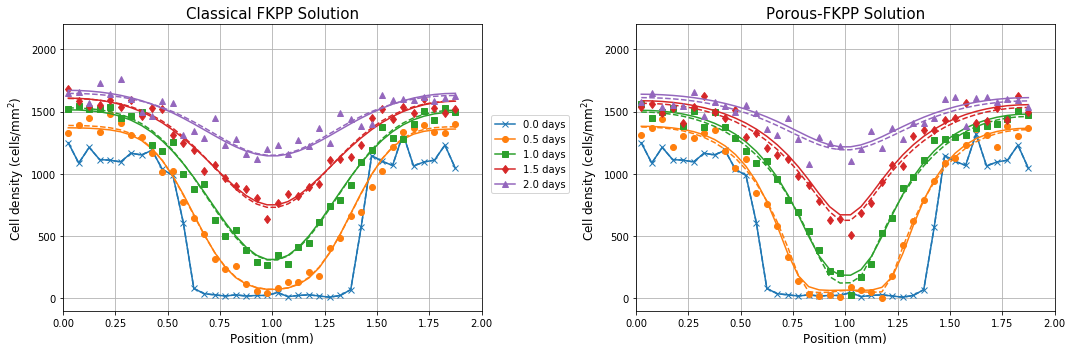

In [7]:
#
# simulated model and parameter fits
#

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
markers = ['x', 'o', 's', 'd', '^']
fig = plt.figure(figsize=(15,5))

#
# FKPP
#

# load data
path = '../Data/'
file_name = 'fisher_KPP_data.npy'
file = np.load(path + file_name, allow_pickle=True).item()
density='     Simulated'
U = file['outputs'].copy()
u0 = U[:,0].copy()
shape = U.shape
U_clean = file['clean'].copy()
x = np.unique(file['inputs'][:,0]).copy()
t = np.unique(file['inputs'][:,1]).copy()
X = file['inputs'][:,0].copy().reshape(shape)
T = file['inputs'][:,1].copy().reshape(shape) 
D = file['D']
r = file['r']
K = file['K']
gamma = 0.2
x_min, x_max = np.min(x), np.max(x)
t_min, t_max = np.min(t), np.max(t)
u_min, u_max = np.min(U), np.max(U)
inputs = np.concatenate([X.reshape(-1)[:, None],T.reshape(-1)[:, None]], axis=1)
outputs = U.reshape(-1)[:, None]

# load model
model.save_name = '../Weights/'
model.save_name += file_name[:-4]+'_simulated'
model.load(model.save_name+'_'+binn.name+weight+'_best_eval_model', device=device)

# learned diffusion term
def diffusion(u,t):
    if binn.diffusion.inputs == 1:
        D = binn.diffusion(to_torch(u)[:, None])
        s = binn.delay1(to_torch(np.array(t).reshape(1,1)))
        return to_numpy(D*s).reshape(-1)
    else:
        D = binn.diffusion(to_torch(u)[:, None],
                           to_torch(t*np.ones_like(u))[:, None])
        return to_numpy(D).reshape(-1)

# learned growth term
def growth(u,t):
    if binn.growth.inputs == 1:
        r = binn.growth(to_torch(u)[:, None])
        s = binn.delay2(to_torch(np.array(t).reshape(1,1)))
        return to_numpy(r*s).reshape(-1)
    else:
        r = binn.growth(to_torch(u)[:, None],
                        to_torch(t*np.ones_like(u))[:, None])
        return to_numpy(r).reshape(-1)

# simulate PDE
u_sim = PDE_sim(PDE_RHS, u0, x, t, diffusion, growth)

ax = fig.add_subplot(1, 2, 1)
for i in range(len(X.T)):
    plt.plot(-1, -1, markers[i]+'-', c=colors[i])
for i in range(len(X.T)):
    plt.plot(X[:,i], U[:,i], marker=markers[i], c=colors[i], linestyle='')
    plt.plot(x, u_sim[:,i], '-', c=colors[i])
    plt.plot(x, U_clean[:,i], '--', c=colors[i])
title = 'Classical FKPP Solution'
plt.title(title, fontsize=15)
ax.set_xlabel('Position (mm)', fontsize=12)
ax.set_ylabel(r'Cell density (cells/mm$^2$)', fontsize=12)
plt.legend(['0.0 days', '0.5 days', '1.0 days', '1.5 days', '2.0 days'], ncol=1, mode='expand',
           bbox_to_anchor=(1.01, 0.1, 0.21, 0.6)) # (x, y, width, height)
plt.ylim(-100, 2200)
plt.xlim(0, 2)
plt.grid()

#
# PFKPP
#

# load data
path = '../Data/'
file_name = 'porous_fisher_KPP_data.npy'
file = np.load(path + file_name, allow_pickle=True).item()
density='     Simulated'
U = file['outputs'].copy()
u0 = U[:,0].copy()
shape = U.shape
U_clean = file['clean'].copy()
x = np.unique(file['inputs'][:,0]).copy()
t = np.unique(file['inputs'][:,1]).copy()
X = file['inputs'][:,0].copy().reshape(shape)
T = file['inputs'][:,1].copy().reshape(shape) 
D = file['D']
r = file['r']
K = file['K']
gamma = 0.2
x_min, x_max = np.min(x), np.max(x)
t_min, t_max = np.min(t), np.max(t)
u_min, u_max = np.min(U), np.max(U)
inputs = np.concatenate([X.reshape(-1)[:, None],T.reshape(-1)[:, None]], axis=1)
outputs = U.reshape(-1)[:, None]

# load model
model.save_name = '../Weights/'
model.save_name += file_name[:-4]+'_simulated'
model.load(model.save_name+'_'+binn.name+weight+'_best_eval_model', device=device)

# learned diffusion term
def diffusion(u,t):
    if binn.diffusion.inputs == 1:
        D = binn.diffusion(to_torch(u)[:, None])
        s = binn.delay1(to_torch(np.array(t).reshape(1,1)))
        return to_numpy(D*s).reshape(-1)
    else:
        D = binn.diffusion(to_torch(u)[:, None],
                           to_torch(t*np.ones_like(u))[:, None])
        return to_numpy(D).reshape(-1)

# learned growth term
def growth(u,t):
    if binn.growth.inputs == 1:
        r = binn.growth(to_torch(u)[:, None])
        s = binn.delay2(to_torch(np.array(t).reshape(1,1)))
        return to_numpy(r*s).reshape(-1)
    else:
        r = binn.growth(to_torch(u)[:, None],
                        to_torch(t*np.ones_like(u))[:, None])
        return to_numpy(r).reshape(-1)

# simulate PDE
u_sim = PDE_sim(PDE_RHS, u0, x, t, diffusion, growth)

ax = fig.add_subplot(1, 2, 2)
for i in range(len(X.T)):
    plt.plot(-1, -1, markers[i]+'-', c=colors[i])
for i in range(len(X.T)):
    plt.plot(X[:,i], U[:,i], marker=markers[i], c=colors[i], linestyle='')
    plt.plot(x, u_sim[:,i], '-', c=colors[i])
    plt.plot(x, U_clean[:,i], '--', c=colors[i])
title = 'Porous-FKPP Solution'
plt.title(title, fontsize=15)
ax.set_xlabel('Position (mm)', fontsize=12)
ax.set_ylabel(r'Cell density (cells/mm$^2$)', fontsize=12)
plt.ylim(-100, 2200)
plt.xlim(0, 2)
plt.grid()

plt.tight_layout(h_pad=2, w_pad=2)
plt.savefig('../Figures/simulated_model_fits.pdf', format='pdf')
plt.show()